# Overview
Steps to build the network:

1. Load the training data and do a train/validation split.
3. Build a convolutional neural network to classify traffic signs.
4. Build a feedforward neural network to classify traffic signs.
5. Evaluate performance of final neural network on testing data.

Keep an eye on the network’s accuracy over time. Once the accuracy reaches the 98% range, you can be confident that you’ve built and trained an effective model.

In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

from keras.models import Sequential
from keras.layers import Dense, Activation
import cv2

import json
import random

Using TensorFlow backend.


Load the Data

In [2]:
# read new images

data = pd.read_csv('data/new_data/new_log.csv',
                   dtype={'center': str,'steering': np.float32},
                   skipinitialspace=1)
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))

print('Data loaded')


center       object
steering    float32
dtype: object
Training data size =  13935
Training labels size =  13935
Data loaded


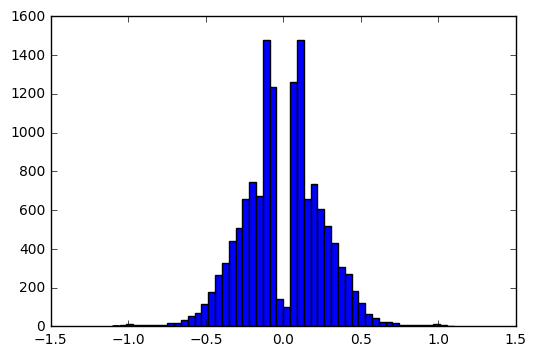

X_train: 13935
y_train: 13935


In [3]:
# examine the data
import matplotlib.pyplot as plt
plt.hist(y_train,50)
plt.show()
data = list(X_train)
labels = list(y_train)
print('X_train:',len(X_train))
print('y_train:',len(y_train))

In [4]:
from sklearn.model_selection import train_test_split

# split data into train, validate and test data
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2,random_state=42)
#print(X_train.shape[0])
print('Data splitted into train, validation anda test data')
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Validation data size = ',len(X_val))
print('Validation labels size = ',len(y_val))
print('Test data size = ',len(X_test))
print('Test labels size = ',len(y_test))

Data splitted into train, validation anda test data
Training data size =  9754
Training labels size =  9754
Validation data size =  3344
Validation labels size =  3344
Test data size =  837
Test labels size =  837


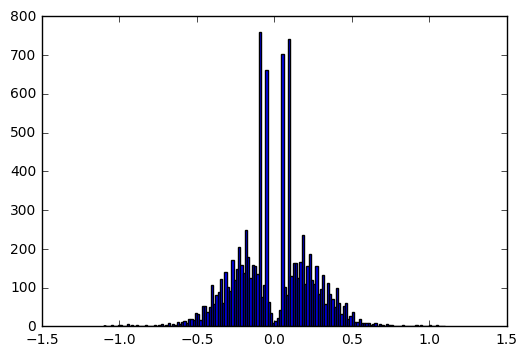

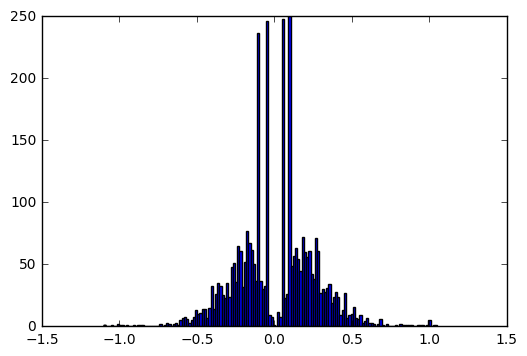

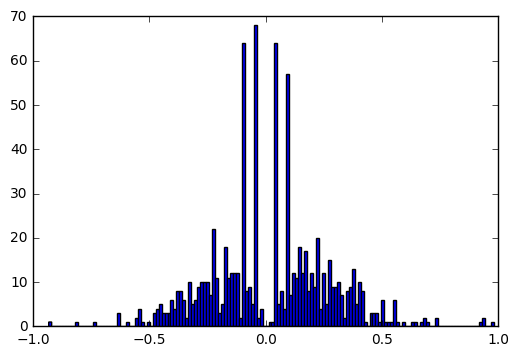

In [5]:
plt.hist(y_train,150)
plt.show()
plt.hist(y_val,150)
plt.show()
plt.hist(y_test,150)
plt.show()

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Lambda
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
# define the model
#print('Input shape:',(X_train[0].shape))
#height,width,depth = X_train[0].shape[0],X_train[0].shape[1],X_train[0].shape[2]
#print('Input size:',height,',',width,',',depth)
#subsample=strides
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(80, 300, 3),output_shape=(80, 300, 3)))
model.add(Conv2D(24, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
#model.add(BatchNormalization()) #normalisation should be done before activation
model.add(Activation('relu'))
model.add(Conv2D(36, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(48, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))

model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv2D(64, 3, 3,subsample=(1, 1),W_regularizer='l2',dim_ordering='tf'))

model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3,subsample=(1, 1),W_regularizer='l2',dim_ordering='tf'))

model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(100, name='fc1'))
model.add(BatchNormalization(mode=1))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(50, name='fc2'))
model.add(BatchNormalization(mode=1))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(10, name='fc3'))
model.add(BatchNormalization(mode=1))
model.add(Activation('relu'))
model.add(Dense(1,name='output'))

# other layers we may add
#model.add(MaxPooling2D((2,2)))

#Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
#keras.layers.normalization.BatchNormalization(epsilon=0.001, mode=0, axis=-1, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)

# for a mean squared error regression problem
model.compile(optimizer=Adam(lr=0.0001),loss='mean_squared_error')
#model.compile(optimizer='rmsprop',loss='mse')
model.summary()
print('Model defined')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 80, 300, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 38, 148, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 38, 148, 24)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 17, 72, 36)    21636       activation_1[0][0]               
___________________________________________________________________________________________

In [7]:
from PIL import Image
    
def generator(X, Y):
    while 1:
        X_sh = []
        Y_sh = []
        index_shuf = list(range(len(Y)))
        random.shuffle(index_shuf)
        for i in index_shuf:
           X_sh.append(X[i])
           Y_sh.append(Y[i])
        for (x, y) in zip(X_sh, Y_sh):
        #for (x, y) in zip(X, Y):
            path, angle = (x, y)
            angle = np.reshape(angle, [1])
            image = Image.open('./data/new_data/' + path)
            image_array = np.asarray(image)
            transformed_image_array = image_array[None, :, :, :]
            #image = cv2.imread('./data/data/' + path)
            #image = np.reshape(image, (1, 160, 320, 3))
            yield transformed_image_array, angle

IMG/image_909.jpg


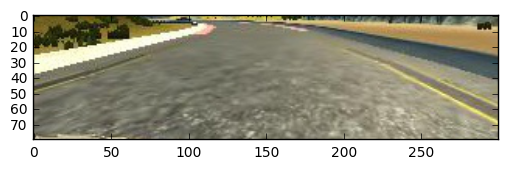

In [8]:
print(X_train[0])
#image = cv2.imread('./data/data/' + X_train[0])
image = Image.open('./data/new_data/' + X_train[0])
image_array = np.asarray(image)
plt.imshow(image)
plt.show()

In [9]:
#train the model
from keras.callbacks import ModelCheckpoint
print('')
iterations = 30
train_batch_size = 1000 #len(y_val) # len(X_train)
val_batch_size = 100#len(y_val)   # len(y_val)  #1928 
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, monitor = 'val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit_generator(generator(X_train, y_train), 
                    samples_per_epoch= train_batch_size,
                    nb_epoch=iterations,
                    callbacks=callbacks_list,
                    verbose=1,
                    validation_data=generator(X_val, y_val),
                    nb_val_samples=val_batch_size)
#history = model.fit(X_train, y_train, batch_size=train_batch_size, nb_epoch=iterations, callbacks=callbacks_list, verbose=1, validation_data=(X_val, y_val))
#history = model.fit_generator(next_batch(X_train,y_train,train_batch_size), samples_per_epoch=5000, nb_epoch=iterations,
  #                 verbose=1, validation_data=next_batch_val(X_val,y_val,val_batch_size), nb_val_samples=1000)
print('----------------- Model trained! -----------------')


Epoch 1/30
1000/1000 [==============================] - 29s - loss: 0.2620 - val_loss: 0.0418
Epoch 2/30
1000/1000 [==============================] - 27s - loss: 0.1961 - val_loss: 0.0277
Epoch 3/30
1000/1000 [==============================] - 27s - loss: 0.1414 - val_loss: 0.0281
Epoch 4/30
1000/1000 [==============================] - 27s - loss: 0.1122 - val_loss: 0.0270
Epoch 5/30
1000/1000 [==============================] - 27s - loss: 0.0839 - val_loss: 0.0237
Epoch 6/30
1000/1000 [==============================] - 28s - loss: 0.0628 - val_loss: 0.0229
Epoch 7/30
1000/1000 [==============================] - 28s - loss: 0.0535 - val_loss: 0.0231
Epoch 8/30
1000/1000 [==============================] - 31s - loss: 0.0434 - val_loss: 0.0280
Epoch 9/30
1000/1000 [==============================] - 34s - loss: 0.0415 - val_loss: 0.0396
Epoch 10/30
1000/1000 [==============================] - 37s - loss: 0.0420 - val_loss: 0.0332
Epoch 11/30
1000/1000 [==============================] - 4

In [10]:
# evaluate the model
scores = model.evaluate_generator(generator(X_test, y_test),len(X_test))
print(scores)

0.0254267170065


In [11]:
from keras.models import model_from_json
import json

# convert model to json format
json_string = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(json_string, outfile)

#save model to files
model.save_weights('model.h5')

print('Model saved to file.')

Model saved to file.


In [ ]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('model.h5')